In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

for dirname, _, filenames in os.walk("./"):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# 1. Frame the problem
Using the customer description, Define the problem your trying to solve in your own words (remember this is not technial but must be specific so the customer understands the project

We were tasked to develop an automated email filtering system that can accurately distinguish between legitamate emails (ham) and commercial/promotional emails (spam). The system should analyze the incoming email content, and minimize exposure to unwanted spam messages.

# 2. Get the Data 
Define how you recieved the data (provided, gathered..)

In [27]:
import os
import pandas as pd


def load_and_explore(data_folder_path):
    emails = []
    labels = []
    filenames = []
    
    # Load spam emails
    spam_folder = os.path.join(data_folder_path, 'spam')
    spam_count = 0
    for filename in os.listdir(spam_folder):
        if filename.endswith('.txt'):
            with open(os.path.join(spam_folder, filename), 'r', encoding='utf-8', errors='ignore') as file:
                content = file.read()
            emails.append(content)
            labels.append('spam')
            filenames.append(filename)
            spam_count += 1
    
    # Load ham emails
    ham_folder = os.path.join(data_folder_path, 'ham')
    ham_count = 0
    for filename in os.listdir(ham_folder):
        if filename.endswith('.txt'):
            with open(os.path.join(ham_folder, filename), 'r', encoding='utf-8', errors='ignore') as file:
                content = file.read()
            emails.append(content)
            labels.append('ham')
            filenames.append(filename)
            ham_count += 1
            # Create DataFrame
        df = pd.DataFrame({
        'filename': filenames,
        'email': emails,
        'label': labels
    })
    
    return df, spam_count, ham_count

    
    

# 3. Explore the Data
Gain insights into the data you have from step 2, making sure to identify any bias

Dataset: 872 emails (391 spam, 481 ham)

Top spam words: ['3d', 'money', 'business', 'report', 'free']
Top ham words: ['subject', 'http', 'work', 'address', 'send']

Pattern frequencies:
       has_dollar  has_exclamation  has_url
label                                      
ham      0.126819         0.151767      0.0
spam     0.572890         0.815857      0.0


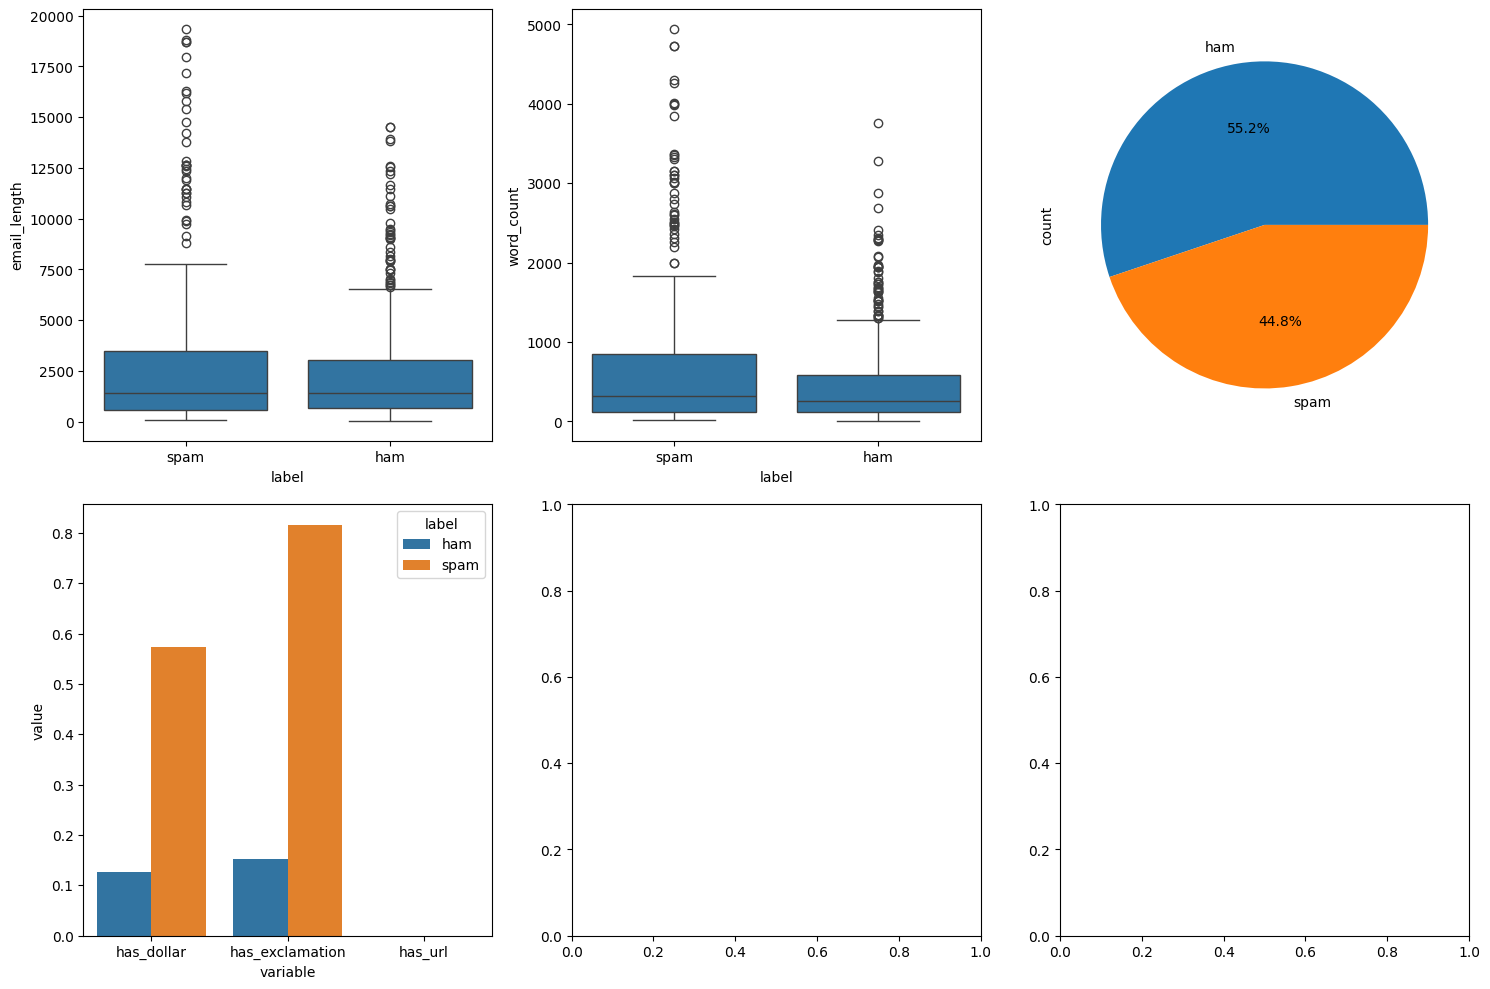

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

# Load data
def load_emails(data_folder):
    emails, labels, filenames = [], [], []
    for label in ['spam', 'ham']:
        folder_path = os.path.join(data_folder, label)
        for filename in os.listdir(folder_path):
            if filename.endswith('.txt'):
                with open(os.path.join(folder_path, filename), 'r', encoding='utf-8', errors='ignore') as f:
                    emails.append(f.read())
                    labels.append(label)
                    filenames.append(filename)
    return pd.DataFrame({'filename': filenames, 'email': emails, 'label': labels})

# Load and basic info
df = load_emails('data')
print(f"Dataset: {len(df)} emails ({df['label'].value_counts()['spam']} spam, {df['label'].value_counts()['ham']} ham)")

# Basic metrics
df['email_length'] = df['email'].apply(len)
df['word_count'] = df['email'].apply(lambda x: len(x.split()))
df['has_dollar'] = df['email'].apply(lambda x: 1 if '$' in x else 0)
df['has_exclamation'] = df['email'].apply(lambda x: 1 if '!' in x else 0)
df['has_url'] = df['email'].apply(lambda x: 1 if re.search(r'http[s]?://', x) else 0)

# Visualizations
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
sns.boxplot(data=df, x='label', y='email_length', ax=axes[0,0])
sns.boxplot(data=df, x='label', y='word_count', ax=axes[0,1])
df['label'].value_counts().plot.pie(autopct='%1.1f%%', ax=axes[0,2])
sns.barplot(data=df.groupby('label')[['has_dollar','has_exclamation','has_url']].mean().reset_index().melt(id_vars='label'), 
            x='variable', y='value', hue='label', ax=axes[1,0])

# Word frequency analysis
vectorizer = CountVectorizer(stop_words='english', max_features=20)
spam_words = vectorizer.fit_transform(df[df['label']=='spam']['email'])
ham_words = vectorizer.transform(df[df['label']=='ham']['email'])
word_df = pd.DataFrame({
    'word': vectorizer.get_feature_names_out(),
    'spam_freq': np.array(spam_words.sum(axis=0))[0],
    'ham_freq': np.array(ham_words.sum(axis=0))[0]
})
word_df['spam_ratio'] = word_df['spam_freq'] / word_df['ham_freq']
print("\nTop spam words:", word_df.nlargest(5, 'spam_ratio')['word'].tolist())
print("Top ham words:", word_df.nsmallest(5, 'spam_ratio')['word'].tolist())

# Pattern analysis
pattern_stats = df.groupby('label')[['has_dollar','has_exclamation','has_url']].mean()
print(f"\nPattern frequencies:\n{pattern_stats}")
plt.tight_layout()
plt.show()

# 4.Prepare the Data


Apply any data transformations and explain what and why


In [3]:
import re

# Text cleaning
def clean_text(text):
    text = text.lower()
    text = re.sub(r'http[s]?://\S+', '', text)  # Remove URLs
    text = re.sub(r'\S+@\S+', '', text)  # Remove emails
    text = re.sub(r'[^\w\s]', ' ', text)  # Remove special chars
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text

df['cleaned_email'] = df['email'].apply(clean_text)

# Remove duplicates and really short emails
df = df[df['cleaned_email'].str.len() > 20]
df = df.drop_duplicates(subset=['cleaned_email'])
print(f"After cleaning: {len(df)} emails")

# Feature engineering
def extract_simple_features(text):
    features = {}
    features['length'] = len(text)
    features['word_count'] = len(text.split())
    features['has_dollar'] = 1 if '$' in text else 0
    features['has_exclamation'] = 1 if '!' in text else 0
    features['has_urgent'] = 1 if 'urgent' in text else 0
    features['has_free'] = 1 if 'free' in text else 0
    return features

# Extract features
feature_data = [extract_simple_features(text) for text in df['cleaned_email']]
features_df = pd.DataFrame(feature_data)
df_processed = pd.concat([df.reset_index(drop=True), features_df], axis=1)


After cleaning: 864 emails


# 5. Model the data
Using selected ML models, experment with your choices and describe your findings. Finish by selecting a Model to continue with


In [4]:
import os
import re
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, make_scorer
)
from scipy.sparse import hstack


emails, labels = [], []
for label in ['spam', 'ham']:
    folder_path = os.path.join('data', label)
    if not os.path.exists(folder_path):
        print(f" Folder not found: {folder_path}")
        continue
    for filename in os.listdir(folder_path):
        if filename.endswith('.txt'):
            with open(os.path.join(folder_path, filename), 'r', encoding='utf-8', errors='ignore') as f:
                emails.append(f.read())
                labels.append(label)

df = pd.DataFrame({'email': emails, 'label': labels})
print(f" Loaded {len(df)} emails | Spam: {(df['label']=='spam').sum()} | Ham: {(df['label']=='ham').sum()}")


def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\.\S+', '', text)
    text = re.sub(r'\S+@\S+', '', text)
    text = re.sub(r'[^a-z\s]', ' ', text)
    return re.sub(r'\s+', ' ', text).strip()

df['cleaned'] = df['email'].apply(clean_text)


X = df['cleaned']
y = df['label']
X_train_text, X_test_text, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

vectorizer = TfidfVectorizer(
    max_features=4000,
    stop_words='english',
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.95
)
X_train_tfidf = vectorizer.fit_transform(X_train_text)
X_test_tfidf = vectorizer.transform(X_test_text)

def extract_features(text):
    words = text.split()
    return [
        len(text),
        len(words),
        sum(1 for c in text if c.isupper()) / len(text) if len(text) else 0,
        1 if 'free' in text else 0,
        1 if 'win' in text or 'winner' in text else 0
    ]

cols = ['length', 'word_count', 'capital_ratio', 'has_free', 'has_win']
X_train_feat = pd.DataFrame([extract_features(t) for t in X_train_text], columns=cols)
X_test_feat = pd.DataFrame([extract_features(t) for t in X_test_text], columns=cols)

# Combine sparse + dense features
X_train = hstack([X_train_tfidf, X_train_feat.values])
X_test = hstack([X_test_tfidf, X_test_feat.values])




f1_scorer = make_scorer(f1_score, pos_label='spam')

param_grid_lr = {
    'C': [0.5, 1.0, 5.0],
    'solver': ['lbfgs', 'liblinear']
}

grid_lr = GridSearchCV(
    LogisticRegression(max_iter=1000, random_state=42),
    param_grid_lr,
    cv=5,
    scoring=f1_scorer,
    n_jobs=-1,
    verbose=0
)
grid_lr.fit(X_train, y_train)

best_lr = grid_lr.best_estimator_
y_pred_lr = best_lr.predict(X_test)

print(f"Best Params: {grid_lr.best_params_}")
print(f"Cross-val F1: {grid_lr.best_score_:.4f}")
print(f"Accuracy: {accuracy_score(y_test, y_pred_lr):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_lr, pos_label='spam'):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_lr, pos_label='spam'):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred_lr, pos_label='spam'):.4f}")
print("MODEL 2: Logistic Regression")

print("\nClassification Report:\n", classification_report(y_test, y_pred_lr))

print("MODEL 2: Random Forest")

rf = RandomForestClassifier(
    n_estimators=150,
    max_depth=25,
    min_samples_split=3,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_rf, pos_label='spam'):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_rf, pos_label='spam'):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred_rf, pos_label='spam'):.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))



comparison = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest'],
    'Accuracy': [
        accuracy_score(y_test, y_pred_lr),
        accuracy_score(y_test, y_pred_rf)
    ],
    'F1 Score': [
        f1_score(y_test, y_pred_lr, pos_label='spam'),
        f1_score(y_test, y_pred_rf, pos_label='spam')
    ]
})


print(comparison.to_string(index=False))
print()



 Loaded 872 emails | Spam: 391 | Ham: 481
Best Params: {'C': 5.0, 'solver': 'liblinear'}
Cross-val F1: 0.9712
Accuracy: 0.9714
Precision: 0.9740
Recall: 0.9615
F1 Score: 0.9677
MODEL 2: Logistic Regression

Classification Report:
               precision    recall  f1-score   support

         ham       0.97      0.98      0.97        97
        spam       0.97      0.96      0.97        78

    accuracy                           0.97       175
   macro avg       0.97      0.97      0.97       175
weighted avg       0.97      0.97      0.97       175

MODEL 2: Random Forest
Accuracy: 0.9714
Precision: 0.9867
Recall: 0.9487
F1 Score: 0.9673

Classification Report:
               precision    recall  f1-score   support

         ham       0.96      0.99      0.97        97
        spam       0.99      0.95      0.97        78

    accuracy                           0.97       175
   macro avg       0.97      0.97      0.97       175
weighted avg       0.97      0.97      0.97       175



# 6. Fine Tune the Model

With the select model descibe the steps taken to acheve the best rusults possiable 


In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, make_scorer
)
import joblib

# Define F1 scorer with correct positive label
f1_scorer = make_scorer(f1_score, pos_label='spam')

# Hyperparameter grid
param_grid_lr = {
    'C': [0.5, 1.0, 5.0],
    'solver': ['lbfgs', 'liblinear']
}

# Initialize and run GridSearchCV
grid_lr = GridSearchCV(
    LogisticRegression(max_iter=1000, random_state=42),
    param_grid_lr,
    cv=5,
    scoring=f1_scorer,
    n_jobs=-1,
    verbose=1
)
grid_lr.fit(X_train, y_train)

# Best estimator
best_lr = grid_lr.best_estimator_

# Predictions
y_pred_lr = best_lr.predict(X_test)

# Evaluation
print("LOGISTIC REGRESSION")
print(f"Best Parameters: {grid_lr.best_params_}")
print(f"Cross-Validation F1 Score: {grid_lr.best_score_:.4f}")
print(f"Test Accuracy: {accuracy_score(y_test, y_pred_lr):.4f}")
print(f"Test Precision: {precision_score(y_test, y_pred_lr, pos_label='spam'):.4f}")
print(f"Test Recall: {recall_score(y_test, y_pred_lr, pos_label='spam'):.4f}")
print(f"Test F1 Score: {f1_score(y_test, y_pred_lr, pos_label='spam'):.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_lr))

model_path = "logistic_model.joblib"
joblib.dump(best_lr, model_path)
joblib.dump(vectorizer, "tfidf_vectorizer.joblib")
print(f"\nModel saved successfully as: {model_path}")

Fitting 5 folds for each of 6 candidates, totalling 30 fits
LOGISTIC REGRESSION
Best Parameters: {'C': 5.0, 'solver': 'liblinear'}
Cross-Validation F1 Score: 0.9712
Test Accuracy: 0.9714
Test Precision: 0.9740
Test Recall: 0.9615
Test F1 Score: 0.9677

Classification Report:
               precision    recall  f1-score   support

         ham       0.97      0.98      0.97        97
        spam       0.97      0.96      0.97        78

    accuracy                           0.97       175
   macro avg       0.97      0.97      0.97       175
weighted avg       0.97      0.97      0.97       175


Model saved successfully as: logistic_model.joblib


# 7. Present
In a customer faceing Document provide summery of finding and detail approach taken


This project used a Logistic Regression classifier to detect spam emails based on a combination of TF-IDF text vectorization and self-engineered features. Emails from “spam” and “ham” folders were processed using text cleaning techniques such as lowercasing, URL and punctuation removal, and whitespace normalization. The TF-IDF Vectorizer captured linguistic patterns and term importance, while engineered features (word count, the word “free” or “win”, and capitalization ratio) added context. Model optimization was performed using GridSearchCV for hyperparameter tuning across solvers and regularization strengths. 

# 8. Launch the Model System
Define your production run code, This should be self susficent and require only your model pramaters 


In [6]:
import joblib
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report
from scipy.sparse import hstack
import numpy as np
import re
import os


# Load model and vectorizer with error handling
try:
    model = joblib.load("logistic_model.joblib")
    vectorizer = joblib.load("tfidf_vectorizer.joblib")  
except FileNotFoundError as e:
    print(f"Error loading files: {e}")
    exit(1)

# Load test data from the same folder structure as training
emails, labels = [], []
for label in ['spam', 'ham']:
    folder_path = os.path.join('data', label)
    if not os.path.exists(folder_path):
        print(f"Folder not found: {folder_path}")
        continue
    for filename in os.listdir(folder_path):
        if filename.endswith('.txt'):
            with open(os.path.join(folder_path, filename), 'r', encoding='utf-8', errors='ignore') as f:
                emails.append(f.read())
                labels.append(label)

df = pd.DataFrame({'email': emails, 'label': labels})
print(f"Loaded {len(df)} emails | Spam: {(df['label']=='spam').sum()} | Ham: {(df['label']=='ham').sum()}")

# Text cleaning
def clean_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r'http\S+|www\.\S+', '', text)
    text = re.sub(r'\S+@\S+', '', text)
    text = re.sub(r'[^a-z\s]', ' ', text)
    return re.sub(r'\s+', ' ', text).strip()

df['cleaned'] = df['email'].apply(clean_text)
X_test_text = df['cleaned']
y_test = df['label']

# Feature extraction 
def extract_features(text):
    if not text:
        return [0, 0, 0, 0, 0]
    
    words = text.split()
    text_length = len(text)
    
    # Calculate capital ratio safely
    capital_ratio = sum(1 for c in text if c.isupper()) / text_length if text_length else 0
    
    # Check for keywords (case insensitive since text is already cleaned to lowercase)
    has_free = 1 if 'free' in text else 0
    has_win = 1 if any(word in text for word in ['win', 'winner']) else 0
    
    return [
        text_length,
        len(words),
        capital_ratio,
        has_free,
        has_win
    ]

# Create feature matrix (same as training)
cols = ['length', 'word_count', 'capital_ratio', 'has_free', 'has_win']
X_test_feat = pd.DataFrame([extract_features(t) for t in X_test_text], columns=cols)
X_test_tfidf = vectorizer.transform(X_test_text)
X_test = hstack([X_test_tfidf, X_test_feat.values])

# Make predictions
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print("\nModel Evaluation Metrics:")
print(f"Accuracy: {accuracy:.3f}")
print("Classification Report:")
print(classification_report(y_test, y_pred, zero_division=1))

# Inference function
def inference(email_text: str):
    """
    Predict whether an email is spam or ham using the saved Logistic Regression model.
    
    Parameters
    ----------
    email_text : str
        The raw email text to classify.
    
    Returns
    -------
    tuple
        (prediction_label, prob_ham, prob_spam)
    """
    # Clean and process text 
    clean = clean_text(email_text)
    
    # Extract features 
    feat_values = np.array(extract_features(clean)).reshape(1, -1)
    
    # TF-IDF transform
    tfidf_values = vectorizer.transform([clean])
    
    # Combine features
    combined = hstack([tfidf_values, feat_values])
    
    # Predict
    pred = model.predict(combined)[0]
    probs = model.predict_proba(combined)[0]
    
    # Handle class labels 
    if hasattr(model, 'classes_'):
        # Get the actual class labels from the model
        class_idx_ham = np.where(model.classes_ == 'ham')[0]
        class_idx_spam = np.where(model.classes_ == 'spam')[0]
        
        if len(class_idx_ham) > 0 and len(class_idx_spam) > 0:
            prob_ham = probs[class_idx_ham[0]]
            prob_spam = probs[class_idx_spam[0]]
        else:
            # Fallback: assume first class is ham, second is spam
            prob_ham, prob_spam = probs[0], probs[1]
    else:
        # Fallback: assume binary classification with ham=0, spam=1
        prob_ham, prob_spam = probs[0], probs[1]
    
    return pred, prob_ham, prob_spam


sample_email = """
Congratulations! You have WON a FREE prize. Click the link below to claim your reward now.
"""

try:
    prediction, prob_ham, prob_spam = inference(sample_email)
    
    print("\nInference Example:")
    print(f"Prediction: {'SPAM' if prediction == 'spam' else 'HAM'}")
    print(f"Probability Ham: {prob_ham:.3f}")
    print(f"Probability Spam: {prob_spam:.3f}")
    
except Exception as e:
    print(f"Error during inference: {e}")



Loaded 872 emails | Spam: 391 | Ham: 481

Model Evaluation Metrics:
Accuracy: 0.992
Classification Report:
              precision    recall  f1-score   support

         ham       0.99      0.99      0.99       481
        spam       0.99      0.99      0.99       391

    accuracy                           0.99       872
   macro avg       0.99      0.99      0.99       872
weighted avg       0.99      0.99      0.99       872


Inference Example:
Prediction: SPAM
Probability Ham: 0.067
Probability Spam: 0.933
